## CRL5 VIF CBF&#946; Benchmarking

In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sys
import time

from src.cullin_benchmark_test import (
    CullinBenchMark,
    accumulate_indicies,
    bar_plot_df_summary,
    binary_search,
    biogrid_df_report,
    check_biogrid_data,
    check_bounds,
    compare_reports,
    find_bounds,
    find_end,
    find_start,
    format_biogrid_df_report,
    get_all_indicies,
    get_biogrid_summary,
    get_json_report_from_report,
    make_bounds,
    show_idmapping_results,
    transform_and_validate_biogrid,
    uniprot_id_mapping,
)

In [2]:
# Global Notebook Flags
CHECK_BIOGRID_DATA = True
GET_BIOGRID_REPORT = True # Expensive
SAVE_BIOGRID_JSON = True
LOAD_BIOGRID_JSON = True
SHOW_BIOGRID_JSON = True

GET_BIOGRID_SUMMARY = True
PLOT_BIOGRID_SUMMARY = True
POST_UNIPROT_IDMAPPING = True
SHOW_UNIPROT_IDMAPPING = True
GET_CULLIN_BG = True
GET_CULLIN_BG_REPORT = True
SHOW_CULLIN_BG_REPORT = True

COMPARE_REPORTS = True

GET_CULLIN_BG_SUMMARY = True
PLOT_CULLIN_BG_SUMMARY = True



In [3]:
cullin_benchmark = CullinBenchMark(dirpath=Path("../data/cullin_e3_ligase"))
#cullin_benchmark.load_data()

#cullin_benchmark.validate_prey()

cullin_benchmark.data.loc[cullin_benchmark.failed, "Prey"]

0           vifprotein
63      polpolyprotein
213         nefprotein
214         tatprotein
803     gagpolyprotein
804         revprotein
2084       IGHG1_MOUSE
2085    envpolyprotein
2094        vifprotein
2387        tatprotein
3196        nefprotein
3437       IGHG1_MOUSE
3438    gagpolyprotein
3439        revprotein
4397        vifprotein
5067        tatprotein
5249        revprotein
5465        nefprotein
5695       IGHG1_MOUSE
5696    gagpolyprotein
Name: Prey, dtype: object

In [4]:
%%bash
shasum -c ../data/biogrid/checksum512.txt

../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt: OK


In [5]:
if CHECK_BIOGRID_DATA:
    check_biogrid_data()

Checking biogrid data for missing tabs
Passed
n-lines 2312699


In [6]:
# Load Biogrid into memory
biogrid = pd.read_csv("../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt", delimiter="\t")

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
biogrid = transform_and_validate_biogrid(biogrid)

Processing Entrez Gene Interactor A
Processing Entrez Gene Interactor B
Change dtypes to categorical
Select columns


In [8]:
# Long Running Cell
if GET_BIOGRID_REPORT:
    transformed_report = biogrid_df_report(biogrid)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [9]:
# Save the serializable output to json

if SAVE_BIOGRID_JSON:
    json_report = get_json_report_from_report(transformed_report)

    # Save the output of the previous cell
    with open("src/transformed_report.json", "w") as fp:
        json.dump(json_report, fp)


In [10]:
LOAD_BIOGRID_JSON

True

In [11]:
if LOAD_BIOGRID_JSON:
    json_report = json.load(open("src/transformed_report.json", "r"))
if SHOW_BIOGRID_JSON:
    print(format_biogrid_df_report(**json_report))


N interactions 2,312,698
N self-interactions 16,394
N non-self interactions 2,296,304
N unique GeneIds 87,718
N blank GeneIds A 2,545
N blank GeneIds B 61
N blank GeneIds 2,606
N possible edges 3,847,179,903
N unique edges 1,786,581
Edge density 0.046438717321403096%



In [12]:
%%bash
cat src/transformed_report.json

{"n_interactions": 2312698, "n_unique_GeneIds": 87718, "n_self_interactions": 16394, "n_non_self_interactions": 2296304, "n_blank_GeneIds": 2606, "n_unique_edges": 1786581, "n_blank_GeneIdsA": 2545, "n_blank_GeneIdsB": 61, "percent_edge_density": 0.046438717321403096, "n_possible_edges": 3847179903}

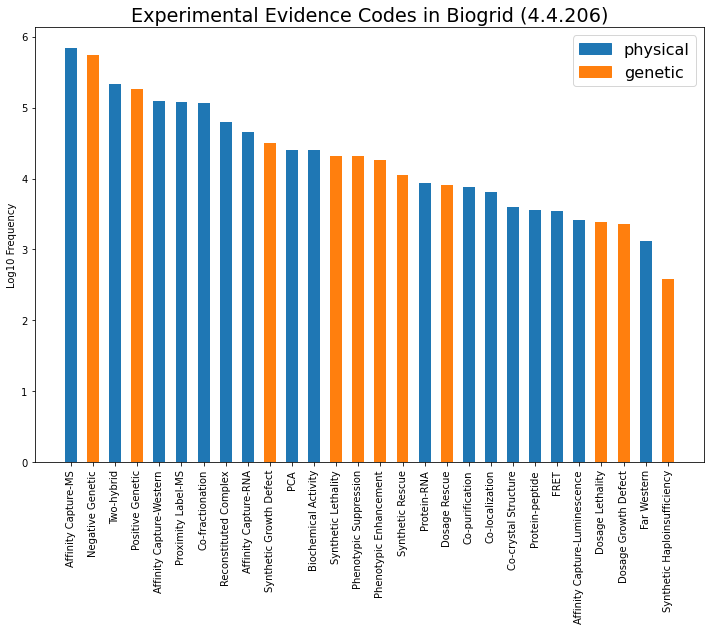

In [13]:
if GET_BIOGRID_SUMMARY:
    summary = get_biogrid_summary(biogrid)
if PLOT_BIOGRID_SUMMARY:
    bar_plot_df_summary(biogrid, summary)

In [14]:
if POST_UNIPROT_IDMAPPING:
    id_mapping, failed_ids, prey_set_idmapping_input = uniprot_id_mapping(cullin_benchmark)
if SHOW_UNIPROT_IDMAPPING:
    show_idmapping_results(id_mapping, failed_ids, prey_set_idmapping_input)

from UniProtKB_AC-ID to GeneID size 5000
POST https://rest.uniprot.org/idmapping/run
          respone  200
          jobId 9ddf4e15f0ef8ad123ccc32fe8cd584c1213447c
Waiting 15 s
GET https://rest.uniprot.org/idmapping/status/9ddf4e15f0ef8ad123ccc32fe8cd584c1213447c
GET https://rest.uniprot.org/idmapping/stream/9ddf4e15f0ef8ad123ccc32fe8cd584c1213447c
13 failed to map
2834 succeeded
of 2847 total


Prior Mappings  
13 failed to map  
2834 succeeded  
of 2847 total  


In [15]:
# Check the Failed Cases
failed_df = cullin_benchmark.data[cullin_benchmark.data['Prey'].apply(lambda x: x in failed_ids)]

# The failed cases amount to only 20 Bait prey Pairs
# The Saint Score < 0.14 for all cases
# Therefore we ignore the 13 failed cases instead of mapping them
# Except for L0R6Q1. Consider for later

In [16]:
eids = set(val for key, val in id_mapping.items())

colA = "Entrez Gene Interactor A"
colB = "Entrez Gene Interactor B"

col = colA
eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
eids_in_biogrid.remove(None)
bounds_A = make_bounds(biogrid, col, eids_in_biogrid)

col = colB
eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
eids_in_biogrid.remove(None)
bounds_B = make_bounds(biogrid, col, eids_in_biogrid)
            

check_bounds(biogrid, bounds_A, eids, colnum=1)
check_bounds(biogrid, bounds_B, eids, colnum=2)

In [17]:
if GET_CULLIN_BG:
    index_labels = get_all_indicies(biogrid, bounds_A, bounds_B, 1, 2)

    # Look at the subset of biogrid

    cullin_bg = biogrid.loc[index_labels]

    # Validate the data frame
    assert np.all(cullin_bg.iloc[:, 1].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))
    assert np.all(cullin_bg.iloc[:, 2].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))

    nnodes = len(eids_in_biogrid)
    n_possible_edges = int(0.5*nnodes*(nnodes-1))

    nself = len(cullin_bg[cullin_bg.iloc[:, 1]==cullin_bg.iloc[:, 2]])
    not_self = cullin_bg.iloc[:, 1]!=cullin_bg.iloc[:, 2]

    cullin_bg = cullin_bg[not_self]

    df = cullin_bg


    # How many edges are unique?

    


2751 incoming bounds
2822 incoming bounds


In [18]:
if GET_CULLIN_BG_REPORT:
    cullin_report = biogrid_df_report(df)
    


0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [19]:
SHOW_CULLIN_BG_REPORT

True

In [20]:
if SHOW_BIOGRID_JSON:
    print("Biogrid Report")
    print(format_biogrid_df_report(**json_report))
if SHOW_CULLIN_BG_REPORT:
    print("Cullin BG Report")
    print(format_biogrid_df_report(**cullin_report))
    
    

Biogrid Report

N interactions 2,312,698
N self-interactions 16,394
N non-self interactions 2,296,304
N unique GeneIds 87,718
N blank GeneIds A 2,545
N blank GeneIds B 61
N blank GeneIds 2,606
N possible edges 3,847,179,903
N unique edges 1,786,581
Edge density 0.046438717321403096%

Cullin BG Report

N interactions 158,002
N self-interactions 0
N non-self interactions 158,002
N unique GeneIds 2,814
N blank GeneIds A 0
N blank GeneIds B 0
N blank GeneIds 0
N possible edges 3,957,891
N unique edges 109,284
Edge density 2.7611675005703793%



In [21]:
if COMPARE_REPORTS:
    json_cullin_report = get_json_report_from_report(cullin_report)
    report_comparison = compare_reports(json_report, json_cullin_report, "Biogrid", "Cullin")

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


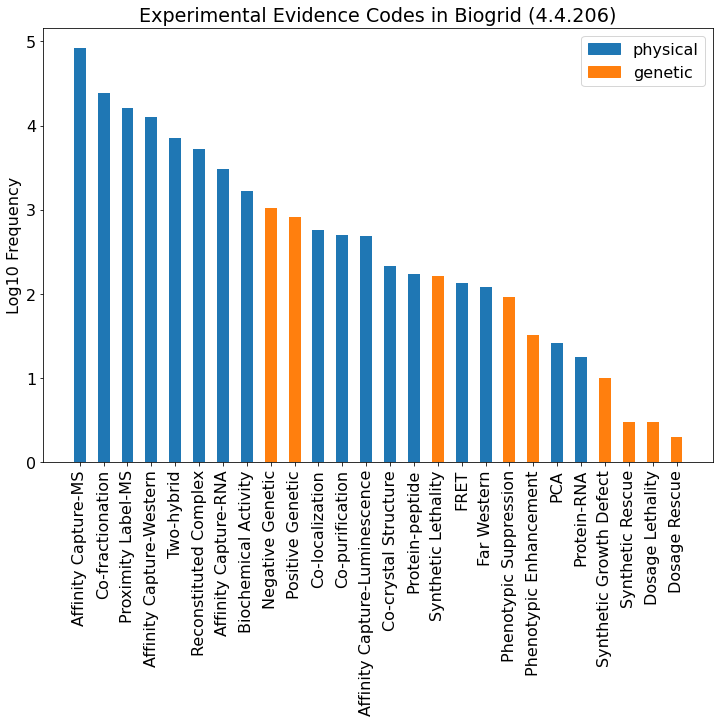

In [24]:
if GET_CULLIN_BG_SUMMARY:
    cullin_bg_summary = get_biogrid_summary(cullin_bg)
if PLOT_CULLIN_BG_SUMMARY:
    bar_plot_df_summary(cullin_bg, cullin_bg_summary)

In [26]:
report_comparison

,Biogrid,Cullin,A/B,log2(A/B),|A-B|
n_interactions,2.312698e+06,1.580020e+05,14.637144,3.871562,2.154696e+06
n_unique_GeneIds,8.771800e+04,2.814000e+03,31.171997,4.962179,8.490400e+04
n_self_interactions,1.639400e+04,0.000000e+00,inf,inf,1.639400e+04
n_non_self_interactions,2.296304e+06,1.580020e+05,14.533386,3.861299,2.138302e+06
n_blank_GeneIds,2.606000e+03,0.000000e+00,inf,inf,2.606000e+03
n_unique_edges,1.786581e+06,1.092840e+05,16.348056,4.031047,1.677297e+06
n_blank_GeneIdsA,2.545000e+03,0.000000e+00,inf,inf,2.545000e+03
n_blank_GeneIdsB,6.100000e+01,0.000000e+00,inf,inf,6.100000e+01
percent_edge_density,4.643872e-02,2.761168e+00,0.016819,-5.893806,2.714729e+00
n_possible_edges,3.847180e+09,3.957891e+06,972.027755,9.924854,3.843222e+09


In [135]:
nodes = cullin_report['unique_GeneId_set']
d =pd.DataFrame(data = np.zeros((len(nodes), len(nodes))), index = nodes, columns = nodes, dtype=int)
print('{:,}'.format(d.values.nbytes))

def get_experimental_coverage_df(biogrid_df, report):
    
    df = biogrid_df
    nodes = report['unique_GeneId_set']
    nodes = sorted(nodes)
    d =pd.DataFrame(data = np.zeros((len(nodes), len(nodes))), index = nodes, columns = nodes, dtype=float)
    
    experiments = {key: i for i, key in enumerate(set(df["Experimental System"]))}
    
    j = 0
    for i, row in biogrid_df.iterrows():
        nodeA = row.iloc[1]
        nodeB = row.iloc[2]
        
        if nodeB > nodeA:
            t = nodeA
            nodeA = nodeB
            nodeB = t
        
        experiment = row["Experimental System"]
        val = experiments[experiment]
        
        d.loc[nodeA, nodeB] += val
        j +=1

    return d
        
        
        
        




63,348,768


In [270]:
def split(u):
    a = u.split("|")
    for i in a:
        assert i.isdigit()
    a = [int(i) for i in a]
    for i in a:
        assert 0 <= i < 256
    a = np.array(a)
    return a

def to_entrez(u, id_mapping):
    return id_mapping[u] if u in id_mapping else "-"

def transform_cullin_benchmark_data(df, id_mapping):
    out = np.zeros((len(df), 4))
    out_ctrl = np.zeros((len(df), 12))
    entrez = []
    j=0
    for i, row in df.iterrows():
        out[j, :] = split(row["Spec"])
        out_ctrl[j, :] = split(row["ctrlCounts"])
        entrez.append(to_entrez(row["Prey"], id_mapping))
        j+=1
    
    
    for i in range(1, 5):
        #assert f"r{i}" not in df.columns
        df[f"r{i}"] = out[:, i-1]
        
    for i in range(1, 13):
        #assert f"ctrl_{i}" not in df.columns
        df[f"ctrl_{i}"] = out_ctrl[:, i-1]
        
    assert "Entrez" not in df.columns
    df["Entrez"] = entrez
    
    return df

    

In [271]:
TRANSFORM_CULLIN = True
if TRANSFORM_CULLIN == True:
    cullin_benchmark_transformed = transform_cullin_benchmark_data(cullin_benchmark.data, id_mapping)

In [136]:
d = get_experimental_coverage_df(cullin_bg, cullin_report)

In [317]:
def cullin_benchmark_report(df):
    cbfb_sel = df["Bait"]=="CBFBwt_MG132"
    elob_sel = df["Bait"]=="ELOBwt_MG132"
    cul5_sel = df["Bait"]=="CUL5wt_MG132"
    
    def n_unique(sel, colname):
        return len(set(df.loc[sel, colname]))
    
    n_unique_CBFB_prey = n_unique(cbfb_sel, "Prey")
    n_unique_ELOB_prey = n_unique(elob_sel, "Prey")
    n_unique_CUL5_prey = n_unique(cul5_sel, "Prey")
    
    n_unique_CBFB_entrez = n_unique(cbfb_sel, "Entrez")
    n_unique_ELOB_entrez = n_unique(elob_sel, "Entrez")
    n_unique_CUL5_entrez = n_unique(cul5_sel, "Entrez")
    
    mid_confidence = df["SaintScore"] > 0.01
    
    
    
    return {'n_unique_CBFB_prey': n_unique_CBFB_prey,
           'n_unique_ELOB_prey': n_unique_ELOB_prey,
           'n_unique_CUL5_prey': n_unique_CUL5_prey,
           'n_unique_CBFB_entrez':n_unique_CBFB_entrez,
           'n_unique_ELOB_entrez':n_unique_ELOB_entrez,
           'n_unique_CUL5_entrez':n_unique_CUL5_entrez}

In [318]:
df = cullin_benchmark_transformed
cullin_benchmark_report(df)

{'n_unique_CBFB_prey': 2094,
 'n_unique_ELOB_prey': 2158,
 'n_unique_CUL5_prey': 2303,
 'n_unique_CBFB_entrez': 2078,
 'n_unique_ELOB_entrez': 2145,
 'n_unique_CUL5_entrez': 2292}

In [313]:
df.apply(lambda x: len(set(x)))

Bait                3
Prey             2855
PreyGene         2855
Spec             2574
SpecSum           267
AvgSpec           267
NumReplicates       1
ctrlCounts       1895
AvgP               90
MaxP               98
TopoAvgP           90
TopoMaxP           98
SaintScore         90
FoldChange        468
BFDR               82
r1                 98
r2                 99
r3                 98
r4                108
ctrl_1             78
ctrl_2             71
ctrl_3             80
ctrl_4             69
ctrl_5             77
ctrl_6             80
ctrl_7             78
ctrl_8             79
ctrl_9             75
ctrl_10            70
ctrl_11            75
ctrl_12            70
Entrez           2833
dtype: int64

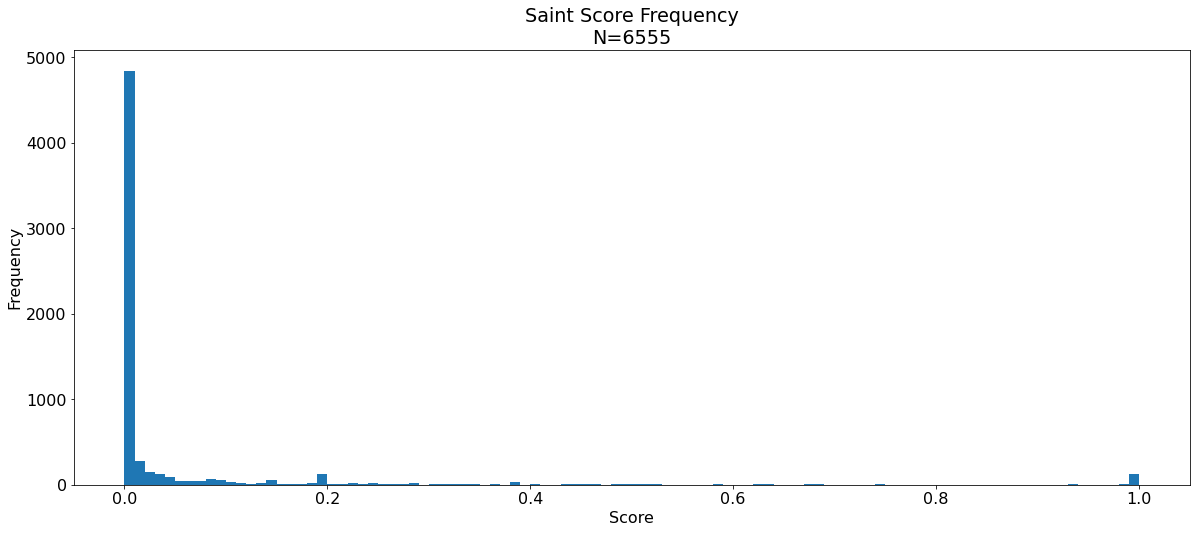

In [164]:
# Look at the Frequency of the Saint Scores
def plot_saint_score_frequency(df, l=8, w=20, title="Saint Score Frequency", bins=100,
                              rcParams={},
                               cmap = matplotlib.cm.tab10.colors
                              ):
    title += f"\nN={len(df)}"
    plt.figure(figsize=(w, l))
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Score")
    plt.hist(df["SaintScore"].values, bins=bins)
    plt.show()
    
plot_saint_score_frequency(cullin_benchmark.data)

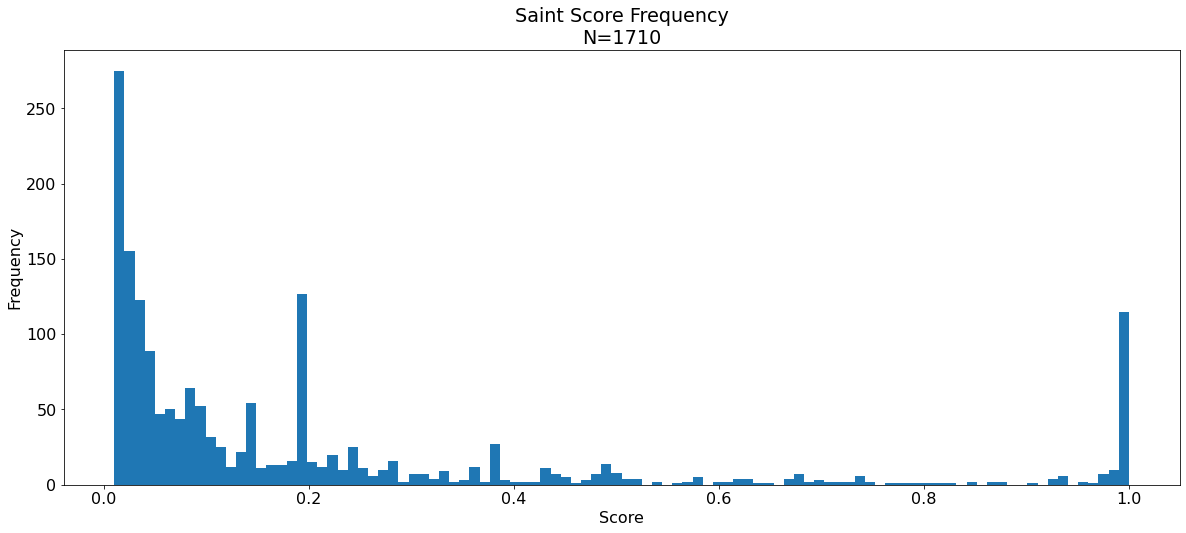

In [385]:
s1 = cullin_benchmark.data["SaintScore"] > 0.001
plot_saint_score_frequency(cullin_benchmark.data[s1])

In [346]:
# Apply a set of filters
# SaintScore > 0.01
# 
df = cullin_benchmark_transformed
thresh = 0.01
s1 = df["SaintScore"] > thresh


s2 = df["Bait"] == "CBFBwt_MG132"
s3 = df["Bait"] == "ELOBwt_MG132"
s4 = df["Bait"] == "CUL5wt_MG132"

s5 = df["Entrez"] != "-"
a = s1 & s2
b = s1 & s3
c = s1 & s4


np.sum(s1), np.sum(s2), np.sum(s1 & s2), np.sum(s1 & s3), np.sum(s1 & s4), np.sum(s1 & s5)

# Select Saint score > thresh and Entrez ID not '-'
df = df[s1 & s5]

In [350]:
df.apply(lambda x: len(set(x)))

Bait                3
Prey             1032
PreyGene         1032
Spec              754
SpecSum           134
AvgSpec           134
NumReplicates       1
ctrlCounts        726
AvgP               88
MaxP               96
TopoAvgP           88
TopoMaxP           96
SaintScore         88
FoldChange        337
BFDR               69
r1                 57
r2                 59
r3                 57
r4                 61
ctrl_1             21
ctrl_2             14
ctrl_3              9
ctrl_4              8
ctrl_5             19
ctrl_6             17
ctrl_7             11
ctrl_8             12
ctrl_9             10
ctrl_10             8
ctrl_11            11
ctrl_12            12
Entrez           1032
dtype: int64

In [351]:
# Train on the first pulldown

s2 = df["Bait"] == "CBFBwt_MG132"
df = df[s2]
df.apply(lambda x: len(set(x)))

Bait               1
Prey             279
PreyGene         279
Spec             182
SpecSum           41
AvgSpec           41
NumReplicates      1
ctrlCounts       239
AvgP              53
MaxP              71
TopoAvgP          53
TopoMaxP          71
SaintScore        53
FoldChange       114
BFDR              55
r1                18
r2                21
r3                23
r4                25
ctrl_1            17
ctrl_2             9
ctrl_3             7
ctrl_4             6
ctrl_5            13
ctrl_6             8
ctrl_7             9
ctrl_8             9
ctrl_9             6
ctrl_10            5
ctrl_11            7
ctrl_12            5
Entrez           279
dtype: int64

In [374]:
#How many positives are there in the training set?

training_index_labels = sorted(df["Entrez"].apply(int))
colA = "Entrez Gene Interactor A"
s1 = cullin_bg[colA].apply(lambda x: int(x) in training_index_labels)
colB = "Entrez Gene Interactor B"
s2 = cullin_bg[colB].apply(lambda x: int(x) in training_index_labels)
s3 = s1 & s2
cullin_train_df = cullin_bg[s3]

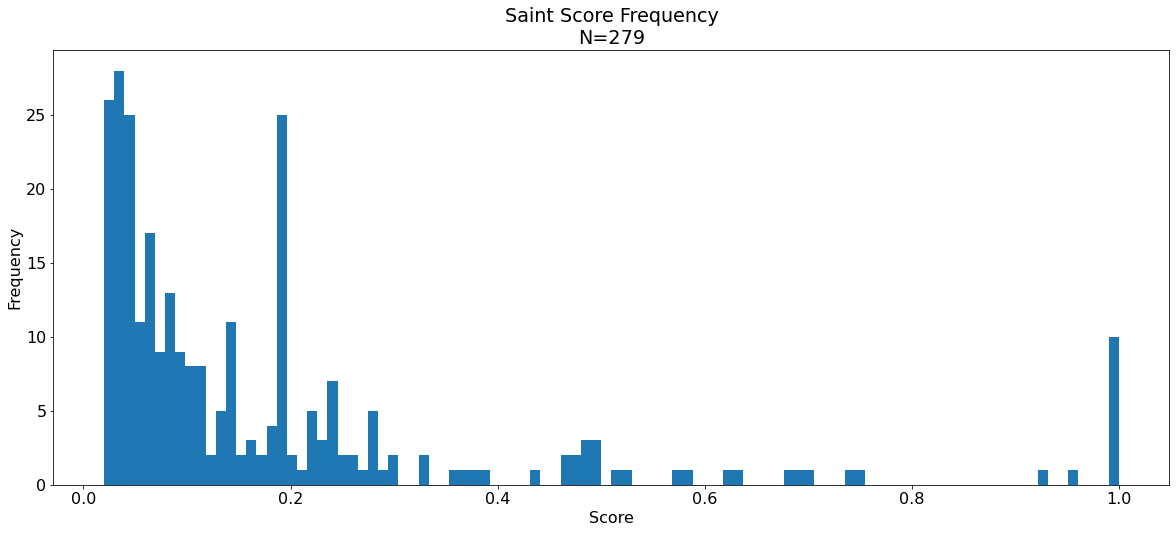

In [376]:
# Plot the Saint Scores for the training Data

plot_saint_score_frequency(df)

In [271]:
TRANSFORM_CULLIN = True
if TRANSFORM_CULLIN == True:
    cullin_benchmark_transformed = transform_cullin_benchmark_data(cullin_benchmark.data, id_mapping)

In [141]:
def triangular_to_symmetric(A):
    Lower = np.tril(A)
    diag_indices = np.diag_indices(len(A))
    Lower = Lower + Lower.T
    Lower[diag_indices] = A[diag_indices]
    return Lower

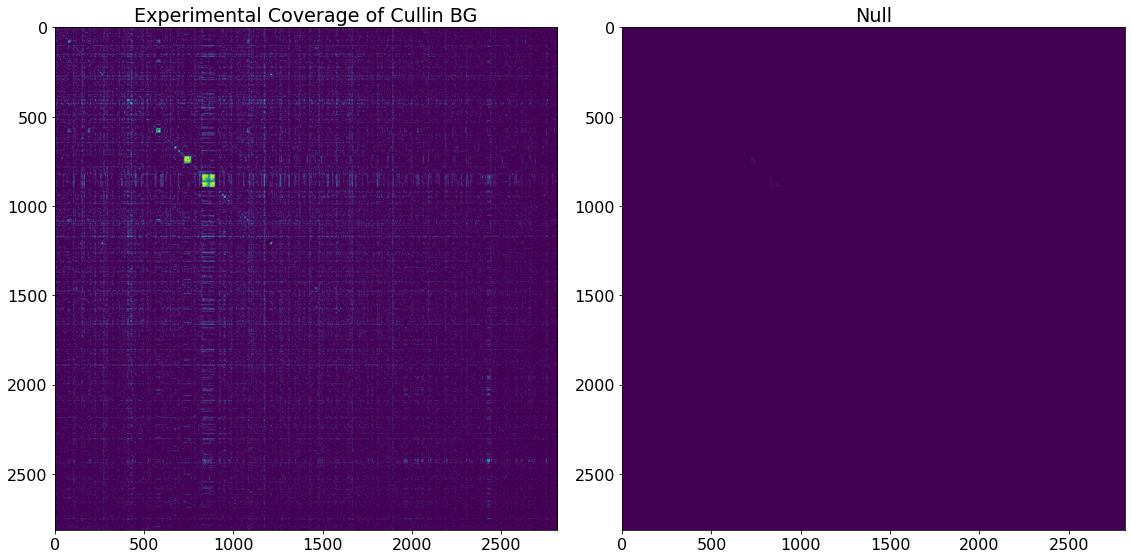

In [386]:
def coverage_plot(d, w=12, h=12, title="Experimental Coverage of Cullin BG"):

    
    
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    
    ax = axs[0]
    mappable = ax.imshow(triangular_to_symmetric(d.values != 0))
    ax.set_title(title)
    #plt.colorbar(mappable, ax=ax)
    ax = axs[1]
    ax.imshow(d.values)
    ax.set_title("Null")
    plt.tight_layout()
    plt.show()
coverage_plot(d, w=16, h=14,)

0.0%
9.97%
19.94%
29.9%
39.87%
49.84%
59.81%
69.77%
79.74%
89.71%
99.68%


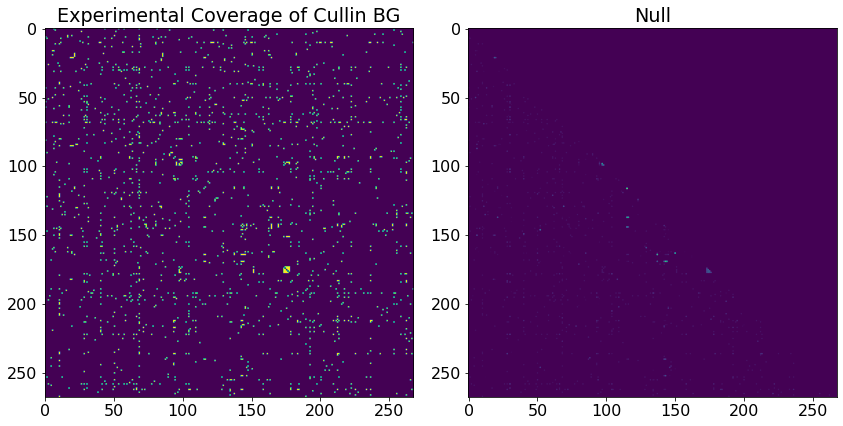

In [393]:
cullin_train_df_report = biogrid_df_report(cullin_train_df)
d_train = get_experimental_coverage_df(cullin_train_df, cullin_train_df_report)

coverage_plot(d_train)

In [395]:
print(format_biogrid_df_report(**cullin_train_df_report))


N interactions 2,468
N self-interactions 0
N non-self interactions 2,468
N unique GeneIds 268
N blank GeneIds A 0
N blank GeneIds B 0
N blank GeneIds 0
N possible edges 35,778
N unique edges 1,495
Edge density 4.178545474872827%



In [396]:
cullin_train_df.shape

(2468, 8)

In [258]:
def plot_spectral_counts_distribution(df,
    columns = ["r1", "r2", "r3", "r4"],
    l=8,
    w=8,
    xlabel="Spectral Counts",
    ylabel="Frequency",
    title="Spectral Counts",
    bins=20,
    cmap=matplotlib.cm.tab10.colors,
    log10=False
):
    plt.figure(figsize=(w, l))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    
    if log10:
        data = np.log10(df[columns].values)
        plt.xlabel("log10 SC")
    else:
        data = df[columns].values
        plt.xlabel(xlabel)
    plt.hist(data, bins=20)
    plt.show()
    

In [ ]:
transformed_cullin_df = transform_cullin_benchmark_data(cullin_benchmark.data)


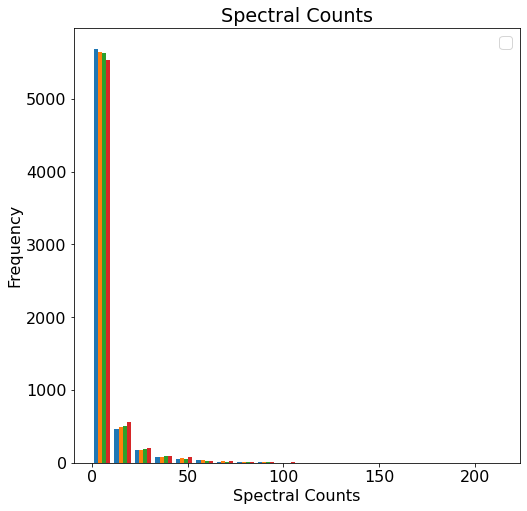

In [259]:
plot_spectral_counts_distribution(transform_cullin_benchmark_data(cullin_benchmark.data), log10=False)